In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import numpy as np
import pandas as pd
import pickle
import os
import re
import itertools as itr
import seaborn as sns
from src.visualize.visualize import plot_correlation_density, plot_vector, plot_lambda_collectivity
from src.enm import Enm

In [70]:
from matplotlib import cm

In [2]:
%load_ext rpy2.ipython


In [3]:
os.chdir('../')

In [4]:
data_path = 'data/interim/pcc_prs_0713/'
with open(f'data/interim/pcc_0601/pcc.pickle','rb') as f:
    e_pcc = pickle.load(f)



In [5]:
e_pcc.figure_path = 'reports/figures//'

In [6]:
e_pcc.get_category("data/interim/strain_ids_with_experiment_count_all.csv")

In [7]:
df = e_pcc.df

In [11]:
import linkcom

In [15]:
e2c, S, D, l = linkcom.cluster(e_pcc.graph_gc,is_weighted=False,to_file=False)

clustering...
computing similarities...
# D_max = 0.249385
# S_max = 0.521739


In [25]:
e2c_val = [i for i in e2c.values()]


In [35]:
nx.set_edge_attributes(e_pcc.graph_gc, e2c, "linkcom")

In [55]:
g = e_pcc.graph_gc
len(np.unique([i[2] for i in g.edges('dal82',data='linkcom')]))

14

In [91]:
def calculate_linkcom_ratio(g):
    return [a/b for a,b in zip([len(np.unique([i[2] for i in x ])) for x in [g.edges(n,data='linkcom') for n in g.nodes]] , [i[1] for i in g.degree()])]

In [92]:
df['linkcom'] = calculate_linkcom_ratio(g)

0       True
1       True
2       True
3       True
4       True
        ... 
5178    True
5179    True
5180    True
5181    True
5182    True
Name: linkcom, Length: 5183, dtype: bool

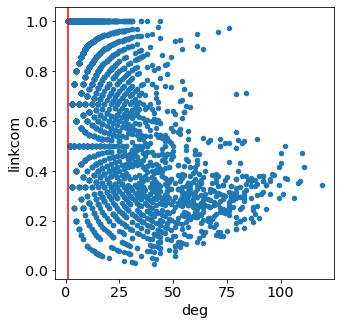

In [76]:
fig, ax = plt.subplots()
df.plot.scatter('deg','linkcom',ax=ax)
ax.axvline(1,c='r')

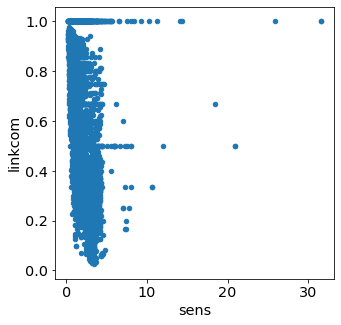

In [80]:
df.loc[df.deg>1].plot.scatter('sens','linkcom')#,c='deg',colormap=cm.viridis_r)

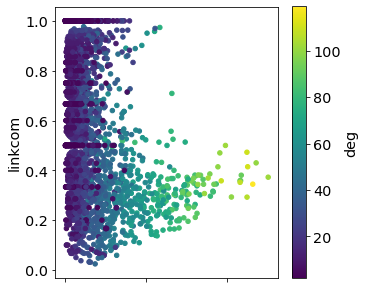

In [83]:
df.loc[df.deg>1].plot.scatter('eff','linkcom',c='deg',colormap=cm.viridis)

In [87]:
rnd_g_list = [e_pcc.e_list[i].graph_gc for i in range(10)]

In [89]:
e2c_list = []
for i in range(10):
    e2c_, S_, D_, l_ = linkcom.cluster(rnd_g_list[i],is_weighted=False,to_file=False)
    e2c_list.append(e2c_)

clustering...
computing similarities...
# D_max = 0.090914
# S_max = 0.180180
clustering...
computing similarities...
# D_max = 0.091531
# S_max = 0.175676
clustering...
computing similarities...
# D_max = 0.090962
# S_max = 0.182482
clustering...
computing similarities...
# D_max = 0.088766
# S_max = 0.183486
clustering...
computing similarities...
# D_max = 0.087555
# S_max = 0.184615
clustering...
computing similarities...
# D_max = 0.091071
# S_max = 0.177778
clustering...
computing similarities...
# D_max = 0.085708
# S_max = 0.196262
clustering...
computing similarities...
# D_max = 0.090122
# S_max = 0.186992
clustering...
computing similarities...
# D_max = 0.083232
# S_max = 0.176471
clustering...
computing similarities...
# D_max = 0.095466
# S_max = 0.178571


In [93]:
[nx.set_edge_attributes(e_pcc.e_list[i].graph_gc, e2c_list[i], "linkcom") for i in range(10)]

[None, None, None, None, None, None, None, None, None, None]

In [96]:
for i in range(10):
    e_pcc.e_list[i].df['linkcom'] = calculate_linkcom_ratio(e_pcc.e_list[i].graph_gc)

In [98]:
e_pcc.e_list[i].df['linkcom']

,orf_name,deg,eig_0,eig_1,eig_2,eig_3,eig_4,eig_5,eig_6,eig_7,eff,sens,btw,trans,eigenvec_centr,closeness_centr,smallest_eigenvec,linkcom
0,dal82,14,0.006173,0.001571,-0.000177,0.004166,-0.001721,0.002111,-0.008011,0.016206,1.025918,0.133808,0.000982,0.032967,0.003538,0.291763,0.000390,0.857143
1,aac1,2,-0.001242,0.000391,-0.001794,0.004165,0.001570,-0.004812,-0.001931,-0.002552,0.039143,0.702793,0.000003,0.000000,0.000101,0.233046,0.000428,1.000000
2,qdr2,12,0.013131,-0.007095,0.019992,-0.050265,-0.009429,-0.001993,0.028090,0.016143,1.253184,0.168386,0.000632,0.015152,0.001102,0.275345,0.000398,0.750000
3,dfg10,7,-0.000433,0.001242,0.000605,-0.001400,-0.009909,0.004105,-0.000073,-0.001291,0.108948,0.186019,0.000079,0.047619,0.002974,0.285919,0.000374,1.000000
4,aac3,2,0.000308,-0.000413,0.000717,-0.000689,-0.000582,-0.067938,0.000314,0.000143,0.004890,0.534974,0.000003,0.000000,0.000752,0.254719,0.000390,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5178,ynl043c,1,-0.000464,0.000214,-0.000172,-0.000010,-0.002566,-0.002311,0.000036,-0.000484,0.063454,1.422807,0.000000,0.000000,0.000027,0.210968,0.000500,1.000000
5179,yol085c,1,0.000360,0.000048,-0.000067,0.000014,-0.000021,-0.002502,-0.000036,0.000097,0.268755,2.955408,0.000000,0.000000,0.000001,0.184282,0.000704,1.000000
5180,yol035c,1,-0.000006,-0.000011,0.000007,0.000004,-0.000037,-0.002605,0.000010,0.000003,0.198620,2.425528,0.000000,0.000000,0.000030,0.205301,0.000626,1.000000
5181,yol159c,1,-0.000095,-0.000032,-0.000909,0.000872,-0.000545,-0.004086,-0.002332,0.000463,0.039846,1.353158,0.000000,0.000000,0.000029,0.214531,0.000493,1.000000


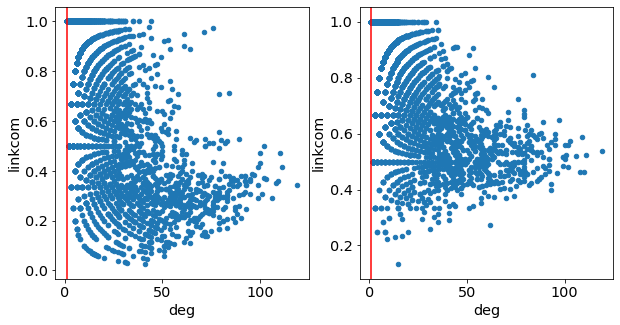

In [101]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
df.plot.scatter('deg','linkcom',ax=ax[0])
ax[0].axvline(1,c='r')
e_pcc.e_list[i].df.plot.scatter('deg','linkcom',ax=ax[1])
ax[1].axvline(1,c='r')

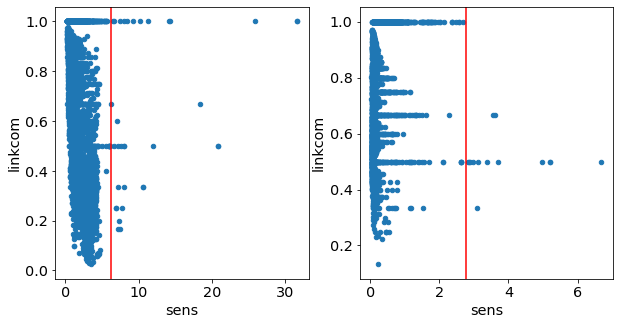

In [109]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
df.query('deg>1').plot.scatter('sens','linkcom',ax=ax[0])
ax[0].axvline(np.quantile(df.sens,0.99),c='r')

e_pcc.e_list[i].df.query('deg>1').plot.scatter('sens','linkcom',ax=ax[1])
ax[1].axvline(np.quantile(e_pcc.e_list[i].df.sens,0.99),c='r')

In [220]:
df['lc'] = df['linkcom']*df['deg']
sensors = df.loc[df.sens>np.quantile(df.sens,0.96)]

In [214]:
cnts=np.bincount(sensors.deg)
breaks=[i for i in range(1+max(sensors.deg))]

In [215]:
nonsensors = df.loc[df.orf_name.isin(sensors.orf_name.values)==False]

In [216]:
def simulate(cnts, breaks, nonsensors ,n=10):
    df_sim = pd.DataFrame(columns = df.columns)
    for itr in range(n):
        for i,j in zip(cnts,breaks):
            #print(j)
            sub = nonsensors.loc[nonsensors.deg==j].sample(n=i)
            df_sim = pd.concat([df_sim,sub])
    return df_sim

In [217]:
df_sim = simulate(cnts,breaks,nonsensors)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fea57a66e10>,
 'caps': [<matplotlib.lines.Line2D at 0x7fea531b9d10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fea531b9090>],
 'medians': [<matplotlib.lines.Line2D at 0x7fea57a40650>],
 'fliers': [],
 'means': []}

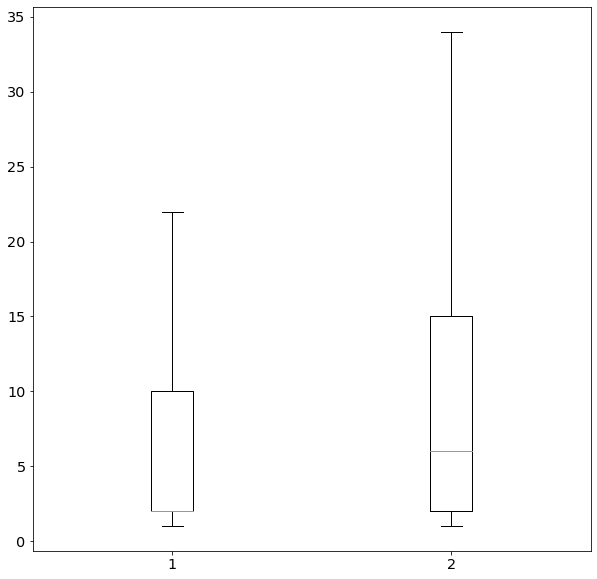

In [224]:
fig,ax= plt.subplots(figsize=(10,10))
ax.boxplot( sensors.query('deg>1').lc,positions=[1],showfliers=False)
ax.boxplot( df_sim.query('deg>1').lc,positions=[2],showfliers=False)
#ax.violinplot( sensors.query('deg>1').linkcom,positions=[1])
#ax.violinplot( df_sim.query('deg>1').linkcom,positions=[2])

In [226]:
df.to_csv('data/interim/0824_df_withlinkcom.csv')